In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/new_version_data.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [3]:
import collections
orderedDict = collections.OrderedDict()


from collections import OrderedDict
import pprint

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import tensorflow as tf
import os
import random
import numpy as np

from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import cv2
np.random.seed = 42


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras import backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

In [7]:
%env SM_FRAMEWORK=tf.keras

!pip install segmentation_models

from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

env: SM_FRAMEWORK=tf.keras
     |████████████████████████████████| 51kB 5.1MB/s 
Segmentation Models: using `tf.keras` framework.


In [8]:
from keras import backend as K

def jacard_coef(y_true,y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)

  intersection = K.sum(y_true_f*y_pred_f)
  return (intersection) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)
  
def jacard_loss(y_true,y_pred):
  return -jacard_coef(y_true,y_pred)

In [9]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras


In [10]:
os.listdir('dataset/new_version_data/PLDM')

['aug_images', 'masks', 'images', 'aug_masks']

# PLDM data set

## Data Import

In [11]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH_x = 'dataset/new_version_data/PLDM/aug_images'
TRAIN_PATH_y = 'dataset/new_version_data/PLDM/aug_masks'
# TEST_PATH = 'stage1_test/'
sub_feat = sorted(os.listdir(TRAIN_PATH_x))
sub_label = sorted(os.listdir(TRAIN_PATH_y))
# train_ids = next(os.walk(TRAIN_PATH))[1]
# test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(sub_feat), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),dtype=np.uint8)
Y_train = np.zeros((len(sub_label), IMG_HEIGHT, IMG_WIDTH,1),dtype = np.uint8)


In [12]:
for i in range(len(sub_feat)):
    img = imread(TRAIN_PATH_x+'/'+sub_feat[i])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[i] = img
    
    img2 = imread(TRAIN_PATH_y+'/'+sub_label[i])
    img2 = resize(img2, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_train[i] = img2[:,:,1].reshape(img2[:,:,1].shape[0],img2[:,:,1].shape[1],1)

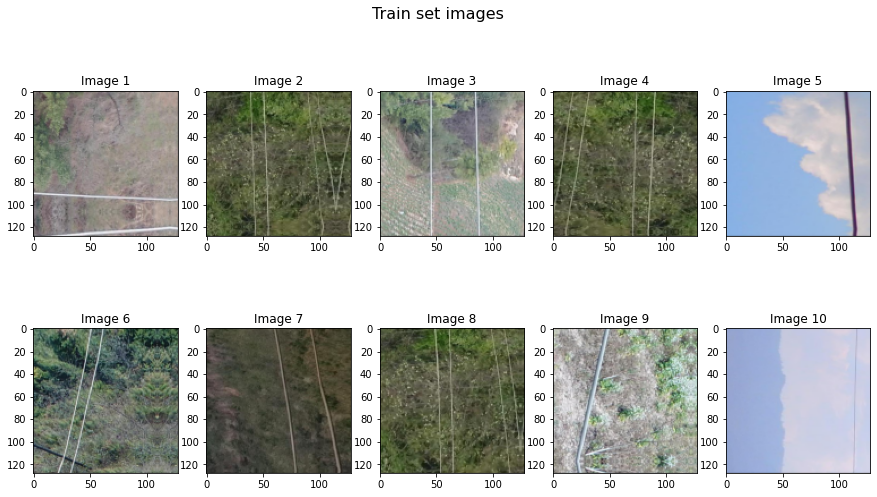

In [13]:
f, axarr = plt.subplots(2,5,figsize=(15,8))
axarr[0,0].imshow(X_train[0])
axarr[0,0].set_title('Image 1')
axarr[0,1].imshow(X_train[1])
axarr[0,1].set_title('Image 2')
axarr[0,2].imshow(X_train[2])
axarr[0,2].set_title('Image 3')
axarr[0,3].imshow(X_train[3])
axarr[0,3].set_title('Image 4')
axarr[0,4].imshow(X_train[4])
axarr[0,4].set_title('Image 5')
axarr[1,0].imshow(X_train[5])
axarr[1,0].set_title('Image 6')
axarr[1,1].imshow(X_train[6])
axarr[1,1].set_title('Image 7')
axarr[1,2].imshow(X_train[7])
axarr[1,2].set_title('Image 8')
axarr[1,3].imshow(X_train[8])
axarr[1,3].set_title('Image 9')
axarr[1,4].imshow(X_train[9])
axarr[1,4].set_title('Image 10')
f.suptitle('Train set images', fontsize=16)
plt.show()

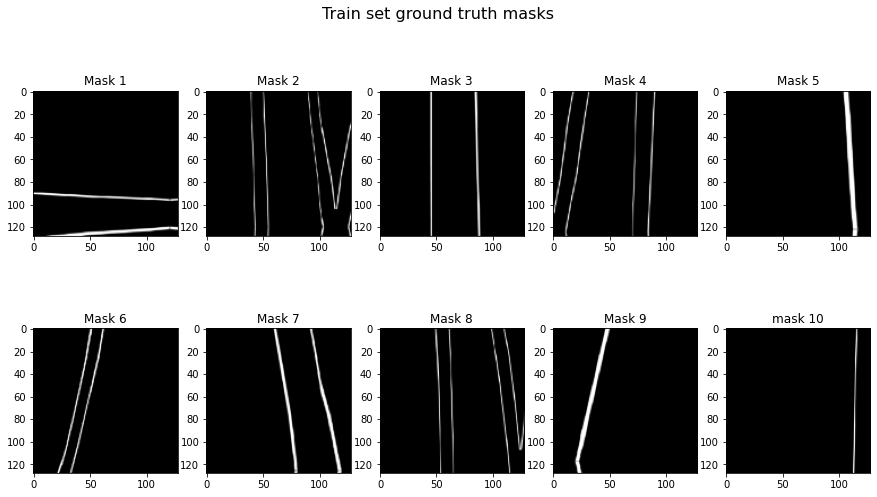

In [14]:
f, axarr = plt.subplots(2,5,figsize=(15,8))
axarr[0,0].imshow(Y_train[0][:,:,0],cmap='gray')
axarr[0,0].set_title('Mask 1')
axarr[0,1].imshow(Y_train[1][:,:,0],cmap='gray')
axarr[0,1].set_title('Mask 2')
axarr[0,2].imshow(Y_train[2][:,:,0],cmap='gray')
axarr[0,2].set_title('Mask 3')
axarr[0,3].imshow(Y_train[3][:,:,0],cmap='gray')
axarr[0,3].set_title('Mask 4')
axarr[0,4].imshow(Y_train[4][:,:,0],cmap='gray')
axarr[0,4].set_title('Mask 5')
axarr[1,0].imshow(Y_train[5][:,:,0],cmap='gray')
axarr[1,0].set_title('Mask 6')
axarr[1,1].imshow(Y_train[6][:,:,0],cmap='gray')
axarr[1,1].set_title('Mask 7')
axarr[1,2].imshow(Y_train[7][:,:,0],cmap='gray')
axarr[1,2].set_title('Mask 8')
axarr[1,3].imshow(Y_train[8][:,:,0],cmap='gray')
axarr[1,3].set_title('Mask 9')
axarr[1,4].imshow(Y_train[9][:,:,0],cmap='gray')
axarr[1,4].set_title('mask 10')
f.suptitle('Train set ground truth masks', fontsize=16)
plt.show()

In [15]:
from sklearn.model_selection import train_test_split
Y_train = Y_train / 255.
X_train = X_train / 255.


train_x,val_x,train_y,val_y = train_test_split(X_train,Y_train,test_size = 0.25) 

## Training the U-Net model

### VGG 16

In [16]:
BACKBONE = 'vgg16'

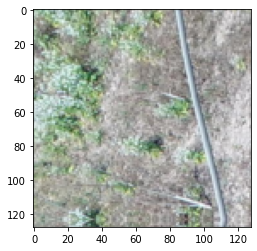

In [17]:
import matplotlib.pyplot as plt
plt.imshow(train_x[0])

In [18]:
model_unet_vgg = 'models/pldm/unet_vgg'

In [19]:
num_thresholds = 15
model = sm.Unet(BACKBONE)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['AUC'])


early_stopping = EarlyStopping(patience=5, verbose=1)
model_checkpoint = ModelCheckpoint(model_unet_vgg, monitor='val_loss', mode='min', save_best_only=True, verbose=1,
                                       save_weights_only=True)
history = model.fit(train_x, train_y,
                        validation_split = 0.2,
                        epochs = 50,
                        batch_size=16,
                        callbacks=[early_stopping,model_checkpoint],
                        verbose=1)

58892288/58889256 [==============================] - 3s 0us/step
Epoch 1/50
23/23 [==============================] - 50s 611ms/step - loss: 0.5750 - auc: 0.7263 - val_loss: 9.4496 - val_auc: 0.7292

Epoch 00001: val_loss improved from inf to 9.44956, saving model to models/pldm/unet_vgg
Epoch 2/50
23/23 [==============================] - 7s 309ms/step - loss: 0.1840 - auc: 0.7813 - val_loss: 0.1289 - val_auc: 0.5979

Epoch 00002: val_loss improved from 9.44956 to 0.12886, saving model to models/pldm/unet_vgg
Epoch 3/50
23/23 [==============================] - 7s 308ms/step - loss: 0.1070 - auc: 0.8666 - val_loss: 0.2206 - val_auc: 0.6811

Epoch 00003: val_loss did not improve from 0.12886
Epoch 4/50
23/23 [==============================] - 7s 308ms/step - loss: 0.0810 - auc: 0.9042 - val_loss: 0.1650 - val_auc: 0.7502

Epoch 00004: val_loss did not improve from 0.12886
Epoch 5/50
23/23 [==============================] - 7s 308ms/step - loss: 0.0646 - auc: 0.9449 - val_loss: 0.1226 - va

In [20]:
model.load_weights(model_unet_vgg)

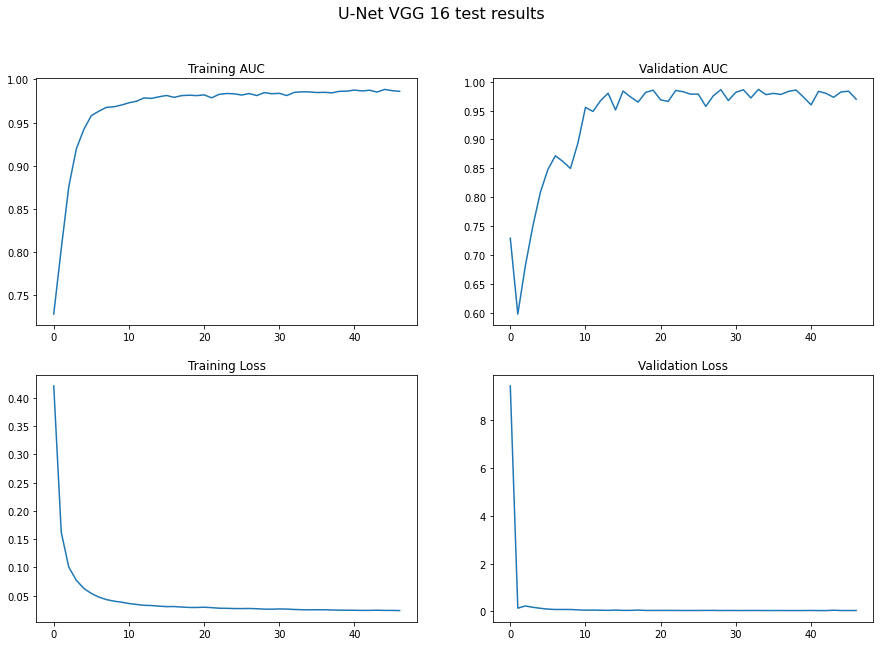

In [21]:
results = history
f, axarr = plt.subplots(2,2,figsize=(15,10))
axarr[0,0].plot(results.history['auc'])
axarr[0,0].set_title('Training AUC')
axarr[0,1].plot(results.history['val_auc'])
axarr[0,1].set_title('Validation AUC')

axarr[1,0].plot(results.history['loss'])
axarr[1,0].set_title('Training Loss')
axarr[1,1].plot(results.history['val_loss'])
axarr[1,1].set_title('Validation Loss')

f.suptitle('U-Net VGG 16 test results', fontsize=16)
plt.show()

In [22]:
tst_vgg = model.predict(val_x)

In [23]:
idx = np.random.choice(range(len(val_x)),5)

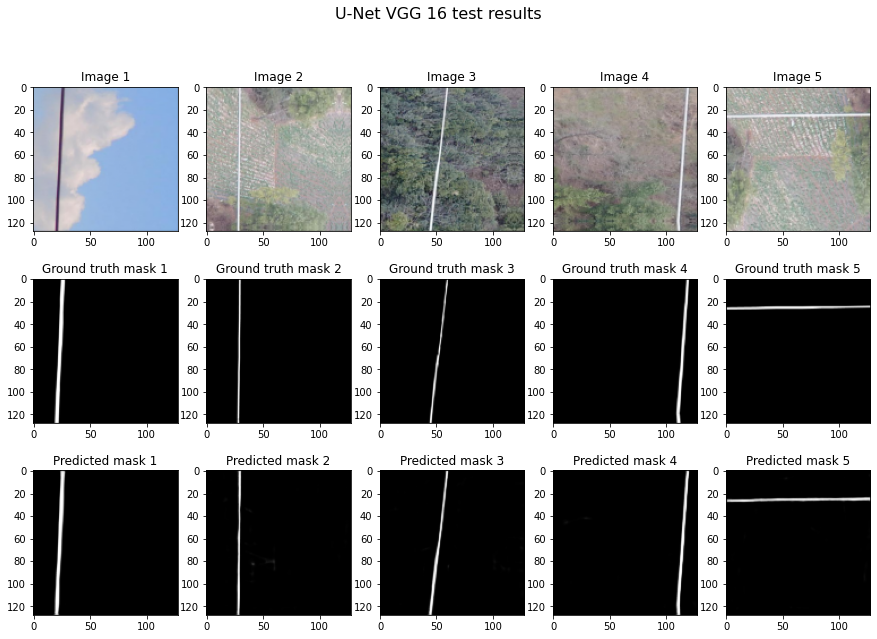

In [24]:
f, axarr = plt.subplots(3,5,figsize=(15,10))
axarr[0,0].imshow(val_x[idx[0]])
axarr[0,0].set_title('Image 1')
axarr[0,1].imshow(val_x[idx[1]])
axarr[0,1].set_title('Image 2')
axarr[0,2].imshow(val_x[idx[2]])
axarr[0,2].set_title('Image 3')
axarr[0,3].imshow(val_x[idx[3]])
axarr[0,3].set_title('Image 4')
axarr[0,4].imshow(val_x[idx[4]])
axarr[0,4].set_title('Image 5')
axarr[1,0].imshow(val_y[idx[0]][:,:,0],cmap='gray')
axarr[1,0].set_title('Ground truth mask 1')
axarr[1,1].imshow(val_y[idx[1]][:,:,0],cmap='gray')
axarr[1,1].set_title('Ground truth mask 2')
axarr[1,2].imshow(val_y[idx[2]][:,:,0],cmap='gray')
axarr[1,2].set_title('Ground truth mask 3')
axarr[1,3].imshow(val_y[idx[3]][:,:,0],cmap='gray')
axarr[1,3].set_title('Ground truth mask 4')
axarr[1,4].imshow(val_y[idx[4]][:,:,0],cmap='gray')
axarr[1,4].set_title('Ground truth mask 5')


axarr[2,0].imshow(tst_vgg[idx[0]][:,:,0],cmap='gray')
axarr[2,0].set_title('Predicted mask 1')
axarr[2,1].imshow(tst_vgg[idx[1]][:,:,0],cmap='gray')
axarr[2,1].set_title('Predicted mask 2')
axarr[2,2].imshow(tst_vgg[idx[2]][:,:,0],cmap='gray')
axarr[2,2].set_title('Predicted mask 3')
axarr[2,3].imshow(tst_vgg[idx[3]][:,:,0],cmap='gray')
axarr[2,3].set_title('Predicted mask 4')
axarr[2,4].imshow(tst_vgg[idx[4]][:,:,0],cmap='gray')
axarr[2,4].set_title('Predicted mask 5')
f.suptitle('U-Net VGG 16 test results', fontsize=16)
plt.show()

In [25]:
num_thresholds = 20
thresholds = [(i + 1) * 1.0 / (num_thresholds - 1) for i in range(num_thresholds - 2)]

In [26]:
vgg_ious = []

for i in thresholds:
  cpy = tst_vgg.copy()
  cpy[cpy >= i] = 1
  cpy[cpy < i] = 0
  vgg_ious.append(float(jacard_coef(val_y.astype('float32'),cpy)))

In [27]:
threshold = thresholds[np.argmax(vgg_ious)]

In [28]:
af_tst_vgg = tst_vgg.copy()
af_tst_vgg[af_tst_vgg >= threshold ] = 1
af_tst_vgg[af_tst_vgg < threshold ] = 0

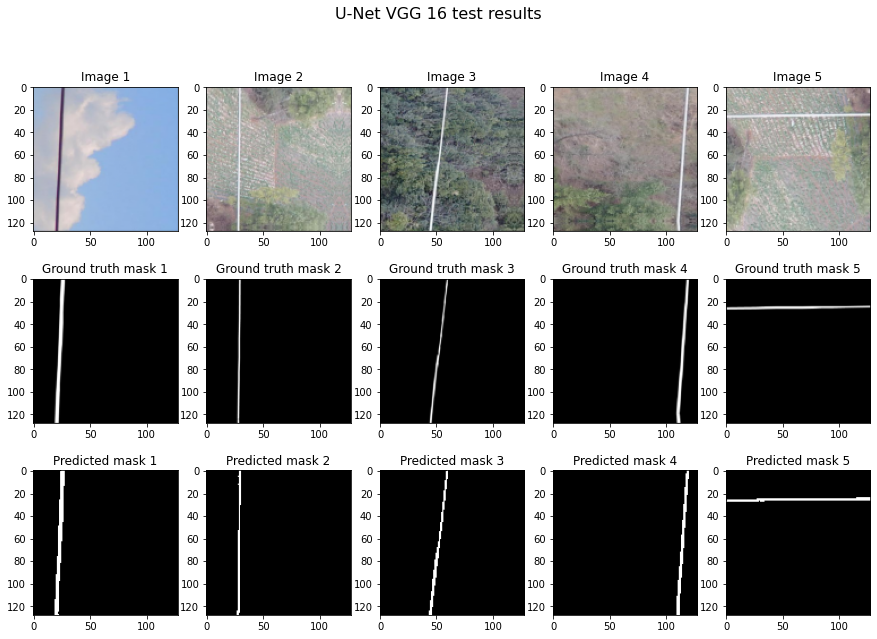

In [29]:
f, axarr = plt.subplots(3,5,figsize=(15,10))
axarr[0,0].imshow(val_x[idx[0]])
axarr[0,0].set_title('Image 1')
axarr[0,1].imshow(val_x[idx[1]])
axarr[0,1].set_title('Image 2')
axarr[0,2].imshow(val_x[idx[2]])
axarr[0,2].set_title('Image 3')
axarr[0,3].imshow(val_x[idx[3]])
axarr[0,3].set_title('Image 4')
axarr[0,4].imshow(val_x[idx[4]])
axarr[0,4].set_title('Image 5')
axarr[1,0].imshow(val_y[idx[0]][:,:,0],cmap='gray')
axarr[1,0].set_title('Ground truth mask 1')
axarr[1,1].imshow(val_y[idx[1]][:,:,0],cmap='gray')
axarr[1,1].set_title('Ground truth mask 2')
axarr[1,2].imshow(val_y[idx[2]][:,:,0],cmap='gray')
axarr[1,2].set_title('Ground truth mask 3')
axarr[1,3].imshow(val_y[idx[3]][:,:,0],cmap='gray')
axarr[1,3].set_title('Ground truth mask 4')
axarr[1,4].imshow(val_y[idx[4]][:,:,0],cmap='gray')
axarr[1,4].set_title('Ground truth mask 5')


axarr[2,0].imshow(af_tst_vgg[idx[0]][:,:,0],cmap='gray')
axarr[2,0].set_title('Predicted mask 1')
axarr[2,1].imshow(af_tst_vgg[idx[1]][:,:,0],cmap='gray')
axarr[2,1].set_title('Predicted mask 2')
axarr[2,2].imshow(af_tst_vgg[idx[2]][:,:,0],cmap='gray')
axarr[2,2].set_title('Predicted mask 3')
axarr[2,3].imshow(af_tst_vgg[idx[3]][:,:,0],cmap='gray')
axarr[2,3].set_title('Predicted mask 4')
axarr[2,4].imshow(af_tst_vgg[idx[4]][:,:,0],cmap='gray')
axarr[2,4].set_title('Predicted mask 5')
f.suptitle('U-Net VGG 16 test results', fontsize=16)
plt.show()

In [30]:
print('IoU score for the U-Net VGG-16 backbone is: {} '.format(float(jacard_coef(val_y.astype('float32'),af_tst_vgg))))

IoU score for the U-Net VGG-16 backbone is: 0.5902292132377625 


### VGG 19

In [48]:
BACKBONE = 'vgg19'

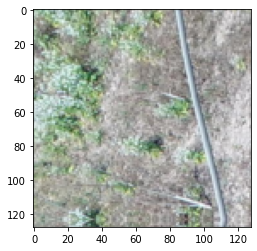

In [49]:
import matplotlib.pyplot as plt
plt.imshow(train_x[0])

In [50]:
model_unet_vgg19 = 'models/unet_vgg19'

In [51]:
num_thresholds = 15
model = sm.Unet(BACKBONE)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['AUC'])


early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(model_unet_vgg19, monitor='val_loss', mode='min', save_best_only=True, verbose=1,
                                       save_weights_only=True)
history = model.fit(train_x, train_y,
                        validation_split = 0.2,
                        epochs = 50,
                        batch_size=16,
                        callbacks=[early_stopping,model_checkpoint],
                        verbose=1)

80142336/80134624 [==============================] - 4s 0us/step
Epoch 1/50
23/23 [==============================] - 11s 371ms/step - loss: 0.6251 - auc: 0.7187 - val_loss: 0.1401 - val_auc: 0.6408

Epoch 00001: val_loss improved from inf to 0.14006, saving model to models/unet_vgg19
Epoch 2/50
23/23 [==============================] - 8s 340ms/step - loss: 0.1851 - auc: 0.8276 - val_loss: 0.3232 - val_auc: 0.7424

Epoch 00002: val_loss did not improve from 0.14006
Epoch 3/50
23/23 [==============================] - 8s 339ms/step - loss: 0.0958 - auc: 0.9150 - val_loss: 0.4048 - val_auc: 0.8545

Epoch 00003: val_loss did not improve from 0.14006
Epoch 4/50
23/23 [==============================] - 8s 340ms/step - loss: 0.0661 - auc: 0.9587 - val_loss: 0.1937 - val_auc: 0.9528

Epoch 00004: val_loss did not improve from 0.14006
Epoch 5/50
23/23 [==============================] - 8s 341ms/step - loss: 0.0533 - auc: 0.9692 - val_loss: 0.0908 - val_auc: 0.9572

Epoch 00005: val_loss improved

In [52]:
model.load_weights(model_unet_vgg19)

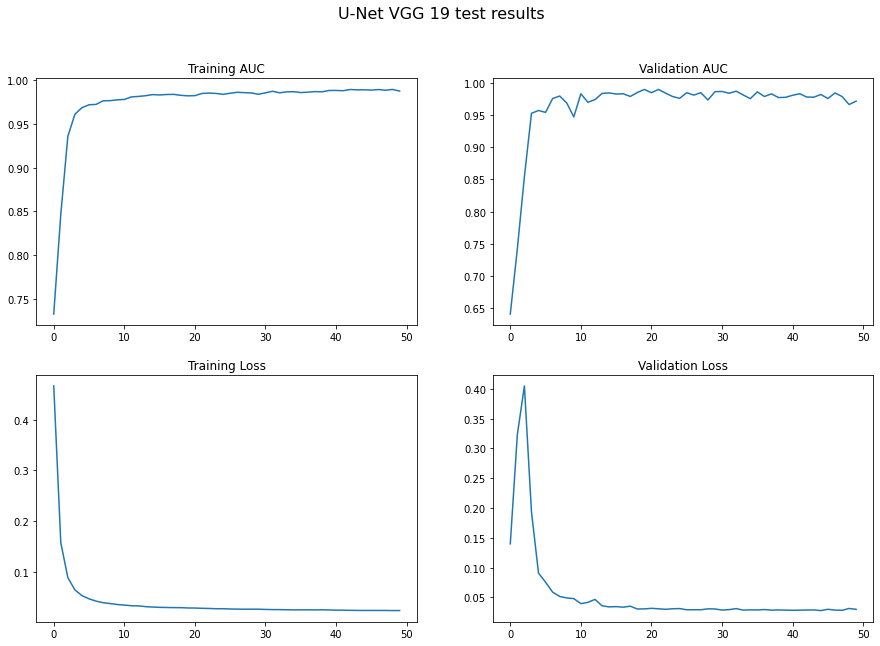

In [53]:
results = history
f, axarr = plt.subplots(2,2,figsize=(15,10))
axarr[0,0].plot(results.history['auc'])
axarr[0,0].set_title('Training AUC')
axarr[0,1].plot(results.history['val_auc'])
axarr[0,1].set_title('Validation AUC')

axarr[1,0].plot(results.history['loss'])
axarr[1,0].set_title('Training Loss')
axarr[1,1].plot(results.history['val_loss'])
axarr[1,1].set_title('Validation Loss')

f.suptitle('U-Net VGG 19 test results', fontsize=16)
plt.show()

In [54]:
tst_vgg19 = model.predict(val_x)

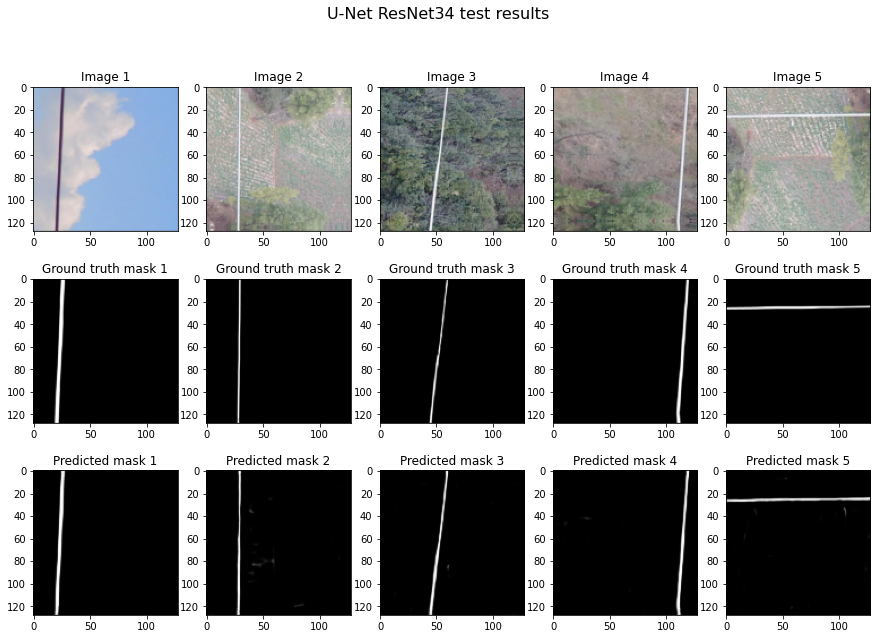

In [55]:
f, axarr = plt.subplots(3,5,figsize=(15,10))
axarr[0,0].imshow(val_x[idx[0]])
axarr[0,0].set_title('Image 1')
axarr[0,1].imshow(val_x[idx[1]])
axarr[0,1].set_title('Image 2')
axarr[0,2].imshow(val_x[idx[2]])
axarr[0,2].set_title('Image 3')
axarr[0,3].imshow(val_x[idx[3]])
axarr[0,3].set_title('Image 4')
axarr[0,4].imshow(val_x[idx[4]])
axarr[0,4].set_title('Image 5')
axarr[1,0].imshow(val_y[idx[0]][:,:,0],cmap='gray')
axarr[1,0].set_title('Ground truth mask 1')
axarr[1,1].imshow(val_y[idx[1]][:,:,0],cmap='gray')
axarr[1,1].set_title('Ground truth mask 2')
axarr[1,2].imshow(val_y[idx[2]][:,:,0],cmap='gray')
axarr[1,2].set_title('Ground truth mask 3')
axarr[1,3].imshow(val_y[idx[3]][:,:,0],cmap='gray')
axarr[1,3].set_title('Ground truth mask 4')
axarr[1,4].imshow(val_y[idx[4]][:,:,0],cmap='gray')
axarr[1,4].set_title('Ground truth mask 5')


axarr[2,0].imshow(tst_vgg19[idx[0]][:,:,0],cmap='gray')
axarr[2,0].set_title('Predicted mask 1')
axarr[2,1].imshow(tst_vgg19[idx[1]][:,:,0],cmap='gray')
axarr[2,1].set_title('Predicted mask 2')
axarr[2,2].imshow(tst_vgg19[idx[2]][:,:,0],cmap='gray')
axarr[2,2].set_title('Predicted mask 3')
axarr[2,3].imshow(tst_vgg19[idx[3]][:,:,0],cmap='gray')
axarr[2,3].set_title('Predicted mask 4')
axarr[2,4].imshow(tst_vgg19[idx[4]][:,:,0],cmap='gray')
axarr[2,4].set_title('Predicted mask 5')
f.suptitle('U-Net ResNet34 test results', fontsize=16)
plt.show()

In [56]:
vgg19_ious = []

for i in thresholds:
  cpy = tst_vgg19.copy()
  cpy[cpy >= i] = 1
  cpy[cpy < i] = 0
  vgg19_ious.append(float(jacard_coef(val_y.astype('float32'),cpy)))

In [57]:
threshold = thresholds[np.argmax(vgg19_ious)]

In [58]:
af_tst_vgg19 = tst_vgg19.copy()
af_tst_vgg19[af_tst_vgg19 >= threshold ] = 1
af_tst_vgg19[af_tst_vgg19 < threshold ] = 0

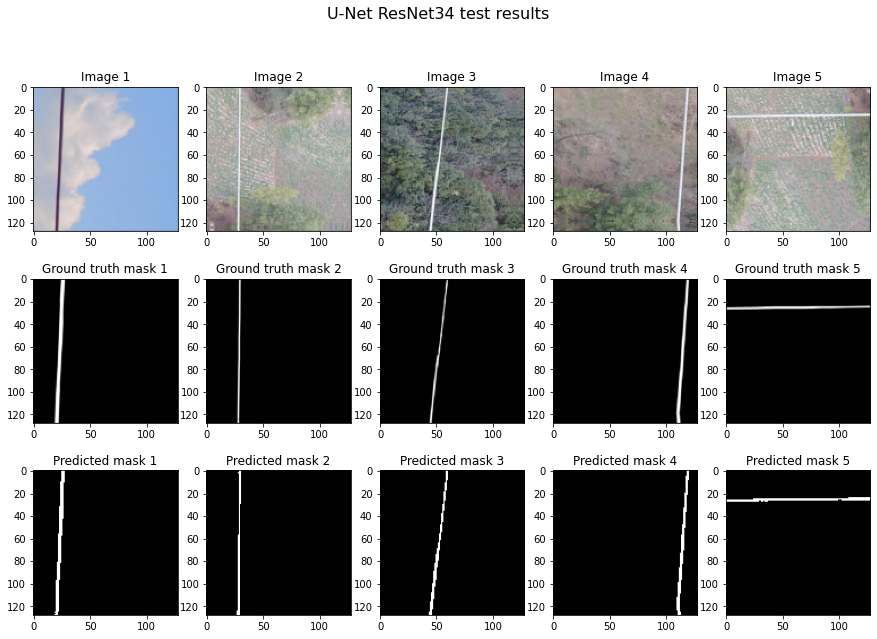

In [59]:
f, axarr = plt.subplots(3,5,figsize=(15,10))
axarr[0,0].imshow(val_x[idx[0]])
axarr[0,0].set_title('Image 1')
axarr[0,1].imshow(val_x[idx[1]])
axarr[0,1].set_title('Image 2')
axarr[0,2].imshow(val_x[idx[2]])
axarr[0,2].set_title('Image 3')
axarr[0,3].imshow(val_x[idx[3]])
axarr[0,3].set_title('Image 4')
axarr[0,4].imshow(val_x[idx[4]])
axarr[0,4].set_title('Image 5')
axarr[1,0].imshow(val_y[idx[0]][:,:,0],cmap='gray')
axarr[1,0].set_title('Ground truth mask 1')
axarr[1,1].imshow(val_y[idx[1]][:,:,0],cmap='gray')
axarr[1,1].set_title('Ground truth mask 2')
axarr[1,2].imshow(val_y[idx[2]][:,:,0],cmap='gray')
axarr[1,2].set_title('Ground truth mask 3')
axarr[1,3].imshow(val_y[idx[3]][:,:,0],cmap='gray')
axarr[1,3].set_title('Ground truth mask 4')
axarr[1,4].imshow(val_y[idx[4]][:,:,0],cmap='gray')
axarr[1,4].set_title('Ground truth mask 5')


axarr[2,0].imshow(af_tst_vgg19[idx[0]][:,:,0],cmap='gray')
axarr[2,0].set_title('Predicted mask 1')
axarr[2,1].imshow(af_tst_vgg19[idx[1]][:,:,0],cmap='gray')
axarr[2,1].set_title('Predicted mask 2')
axarr[2,2].imshow(af_tst_vgg19[idx[2]][:,:,0],cmap='gray')
axarr[2,2].set_title('Predicted mask 3')
axarr[2,3].imshow(af_tst_vgg19[idx[3]][:,:,0],cmap='gray')
axarr[2,3].set_title('Predicted mask 4')
axarr[2,4].imshow(af_tst_vgg19[idx[4]][:,:,0],cmap='gray')
axarr[2,4].set_title('Predicted mask 5')
f.suptitle('U-Net ResNet34 test results', fontsize=16)
plt.show()

In [60]:
print('IoU score for the ResNet 34  backbone is: {} '.format(float(jacard_coef(val_y.astype('float32'),af_tst_vgg19))))

IoU score for the ResNet 34  backbone is: 0.5898510217666626 


### Inception V3

In [61]:
BACKBONE = 'inceptionv3'

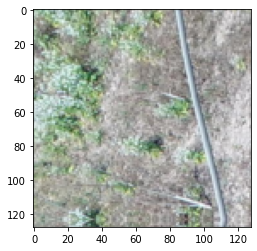

In [62]:
import matplotlib.pyplot as plt
plt.imshow(train_x[0])

In [63]:
model_unet_inception = 'models/unet_inception'

In [64]:
num_thresholds = 15
model = sm.Unet(BACKBONE)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['AUC'])


early_stopping = EarlyStopping(patience=5, verbose=1)
model_checkpoint = ModelCheckpoint(model_unet_inception, monitor='val_loss', mode='min', save_best_only=True, verbose=1,
                                       save_weights_only=True)
history = model.fit(train_x, train_y,
                        validation_split = 0.2,
                        epochs = 50,
                        batch_size=16,
                        callbacks=[early_stopping,model_checkpoint],
                        verbose=1)

87916544/87910968 [==============================] - 1s 0us/step
Epoch 1/50
23/23 [==============================] - 26s 605ms/step - loss: 0.5439 - auc: 0.6661 - val_loss: 0.2818 - val_auc: 0.5107

Epoch 00001: val_loss improved from inf to 0.28182, saving model to models/unet_inception
Epoch 2/50
23/23 [==============================] - 8s 353ms/step - loss: 0.1683 - auc: 0.8462 - val_loss: 0.3490 - val_auc: 0.6195

Epoch 00002: val_loss did not improve from 0.28182
Epoch 3/50
23/23 [==============================] - 8s 352ms/step - loss: 0.1040 - auc: 0.9422 - val_loss: 0.3452 - val_auc: 0.8582

Epoch 00003: val_loss did not improve from 0.28182
Epoch 4/50
23/23 [==============================] - 8s 356ms/step - loss: 0.0764 - auc: 0.9598 - val_loss: 0.2035 - val_auc: 0.9489

Epoch 00004: val_loss improved from 0.28182 to 0.20352, saving model to models/unet_inception
Epoch 5/50
23/23 [==============================] - 8s 352ms/step - loss: 0.0605 - auc: 0.9685 - val_loss: 0.1221 - 

In [65]:
model.load_weights(model_unet_inception)

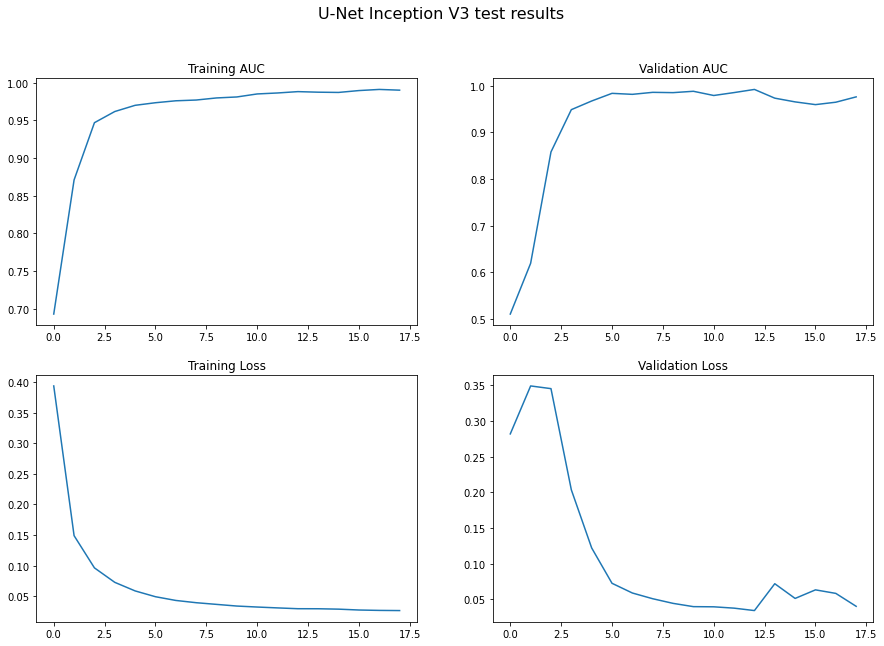

In [66]:
results = history
f, axarr = plt.subplots(2,2,figsize=(15,10))
axarr[0,0].plot(results.history['auc'])
axarr[0,0].set_title('Training AUC')
axarr[0,1].plot(results.history['val_auc'])
axarr[0,1].set_title('Validation AUC')

axarr[1,0].plot(results.history['loss'])
axarr[1,0].set_title('Training Loss')
axarr[1,1].plot(results.history['val_loss'])
axarr[1,1].set_title('Validation Loss')

f.suptitle('U-Net Inception V3 test results', fontsize=16)
plt.show()

In [67]:
tst_inception = model.predict(val_x)

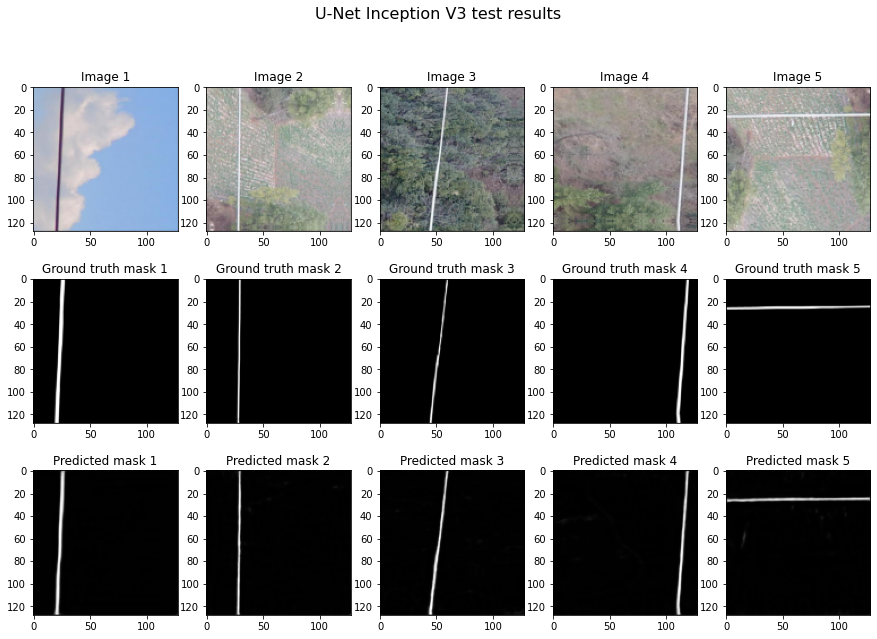

In [68]:
f, axarr = plt.subplots(3,5,figsize=(15,10))
axarr[0,0].imshow(val_x[idx[0]])
axarr[0,0].set_title('Image 1')
axarr[0,1].imshow(val_x[idx[1]])
axarr[0,1].set_title('Image 2')
axarr[0,2].imshow(val_x[idx[2]])
axarr[0,2].set_title('Image 3')
axarr[0,3].imshow(val_x[idx[3]])
axarr[0,3].set_title('Image 4')
axarr[0,4].imshow(val_x[idx[4]])
axarr[0,4].set_title('Image 5')
axarr[1,0].imshow(val_y[idx[0]][:,:,0],cmap='gray')
axarr[1,0].set_title('Ground truth mask 1')
axarr[1,1].imshow(val_y[idx[1]][:,:,0],cmap='gray')
axarr[1,1].set_title('Ground truth mask 2')
axarr[1,2].imshow(val_y[idx[2]][:,:,0],cmap='gray')
axarr[1,2].set_title('Ground truth mask 3')
axarr[1,3].imshow(val_y[idx[3]][:,:,0],cmap='gray')
axarr[1,3].set_title('Ground truth mask 4')
axarr[1,4].imshow(val_y[idx[4]][:,:,0],cmap='gray')
axarr[1,4].set_title('Ground truth mask 5')


axarr[2,0].imshow(tst_inception[idx[0]][:,:,0],cmap='gray')
axarr[2,0].set_title('Predicted mask 1')
axarr[2,1].imshow(tst_inception[idx[1]][:,:,0],cmap='gray')
axarr[2,1].set_title('Predicted mask 2')
axarr[2,2].imshow(tst_inception[idx[2]][:,:,0],cmap='gray')
axarr[2,2].set_title('Predicted mask 3')
axarr[2,3].imshow(tst_inception[idx[3]][:,:,0],cmap='gray')
axarr[2,3].set_title('Predicted mask 4')
axarr[2,4].imshow(tst_inception[idx[4]][:,:,0],cmap='gray')
axarr[2,4].set_title('Predicted mask 5')
f.suptitle('U-Net Inception V3 test results', fontsize=16)
plt.show()

In [69]:
inception_ious = []

for i in thresholds:
  cpy = tst_inception.copy()
  cpy[cpy >= i] = 1
  cpy[cpy < i] = 0
  inception_ious.append(float(jacard_coef(val_y.astype('float32'),cpy)))

In [70]:
threshold = thresholds[np.argmax(inception_ious)]

In [71]:
af_tst_inception = tst_inception.copy()
af_tst_inception[af_tst_inception >= threshold ] = 1
af_tst_inception[af_tst_inception < threshold ] = 0

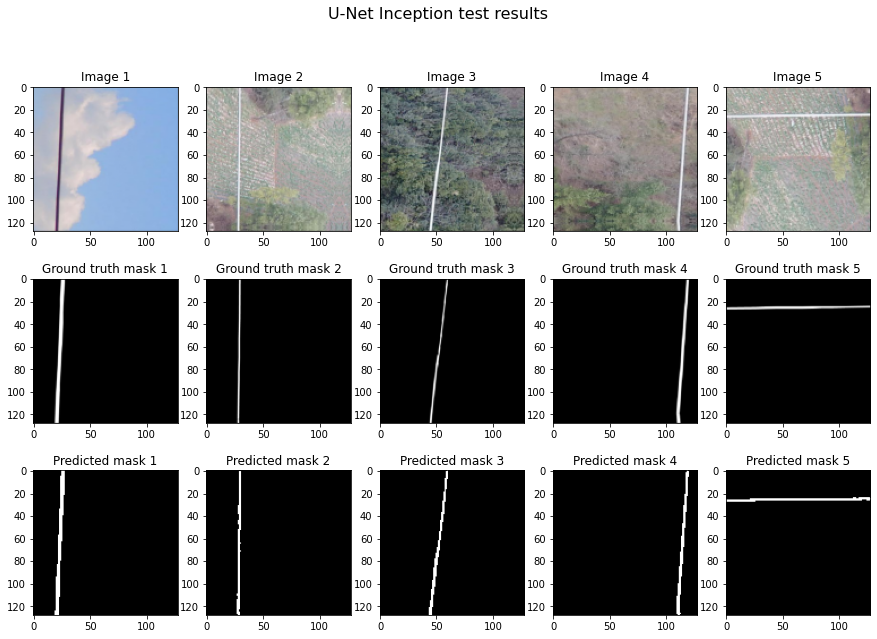

In [72]:
f, axarr = plt.subplots(3,5,figsize=(15,10))
axarr[0,0].imshow(val_x[idx[0]])
axarr[0,0].set_title('Image 1')
axarr[0,1].imshow(val_x[idx[1]])
axarr[0,1].set_title('Image 2')
axarr[0,2].imshow(val_x[idx[2]])
axarr[0,2].set_title('Image 3')
axarr[0,3].imshow(val_x[idx[3]])
axarr[0,3].set_title('Image 4')
axarr[0,4].imshow(val_x[idx[4]])
axarr[0,4].set_title('Image 5')
axarr[1,0].imshow(val_y[idx[0]][:,:,0],cmap='gray')
axarr[1,0].set_title('Ground truth mask 1')
axarr[1,1].imshow(val_y[idx[1]][:,:,0],cmap='gray')
axarr[1,1].set_title('Ground truth mask 2')
axarr[1,2].imshow(val_y[idx[2]][:,:,0],cmap='gray')
axarr[1,2].set_title('Ground truth mask 3')
axarr[1,3].imshow(val_y[idx[3]][:,:,0],cmap='gray')
axarr[1,3].set_title('Ground truth mask 4')
axarr[1,4].imshow(val_y[idx[4]][:,:,0],cmap='gray')
axarr[1,4].set_title('Ground truth mask 5')


axarr[2,0].imshow(af_tst_inception[idx[0]][:,:,0],cmap='gray')
axarr[2,0].set_title('Predicted mask 1')
axarr[2,1].imshow(af_tst_inception[idx[1]][:,:,0],cmap='gray')
axarr[2,1].set_title('Predicted mask 2')
axarr[2,2].imshow(af_tst_inception[idx[2]][:,:,0],cmap='gray')
axarr[2,2].set_title('Predicted mask 3')
axarr[2,3].imshow(af_tst_inception[idx[3]][:,:,0],cmap='gray')
axarr[2,3].set_title('Predicted mask 4')
axarr[2,4].imshow(af_tst_inception[idx[4]][:,:,0],cmap='gray')
axarr[2,4].set_title('Predicted mask 5')
f.suptitle('U-Net Inception test results', fontsize=16)
plt.show()

In [73]:
print('IoU score for the ResNet 34  backbone is: {} '.format(float(jacard_coef(val_y.astype('float32'),af_tst_inception))))

IoU score for the ResNet 34  backbone is: 0.5574467778205872 


#### Conclusion about U-Net model
Best backbone: **VGG-16** \\
Reason: High IoU

## LinkNet model

### VGG 16

In [74]:
BACKBONE = 'vgg16'

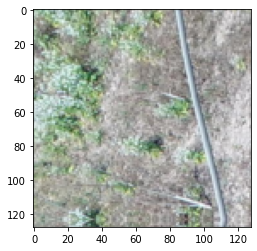

In [75]:
import matplotlib.pyplot as plt
plt.imshow(train_x[0])

In [76]:
model_linknet_vgg = 'models/pldm/linknet_vgg'

In [77]:
# num_thresholds = 15
model = sm.Linknet(BACKBONE)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['AUC'])


early_stopping = EarlyStopping(patience=5, verbose=1)
model_checkpoint = ModelCheckpoint(model_linknet_vgg, monitor='val_loss', mode='min', save_best_only=True, verbose=1,
                                       save_weights_only=True)
history = model.fit(train_x, train_y,
                        validation_split = 0.2,
                        epochs = 50,
                        batch_size=16,
                        callbacks=[early_stopping,model_checkpoint],
                        verbose=1)

Epoch 1/50
23/23 [==============================] - 13s 383ms/step - loss: 0.4468 - auc: 0.6958 - val_loss: 0.2840 - val_auc: 0.8340

Epoch 00001: val_loss improved from inf to 0.28401, saving model to models/pldm/linknet_vgg
Epoch 2/50
23/23 [==============================] - 7s 304ms/step - loss: 0.1394 - auc: 0.9012 - val_loss: 0.1419 - val_auc: 0.7049

Epoch 00002: val_loss improved from 0.28401 to 0.14189, saving model to models/pldm/linknet_vgg
Epoch 3/50
23/23 [==============================] - 7s 304ms/step - loss: 0.0728 - auc: 0.9561 - val_loss: 0.1627 - val_auc: 0.7936

Epoch 00003: val_loss did not improve from 0.14189
Epoch 4/50
23/23 [==============================] - 7s 307ms/step - loss: 0.0549 - auc: 0.9624 - val_loss: 0.1226 - val_auc: 0.8362

Epoch 00004: val_loss improved from 0.14189 to 0.12256, saving model to models/pldm/linknet_vgg
Epoch 5/50
23/23 [==============================] - 7s 305ms/step - loss: 0.0460 - auc: 0.9738 - val_loss: 0.0894 - val_auc: 0.9431


In [78]:
model.load_weights(model_linknet_vgg)

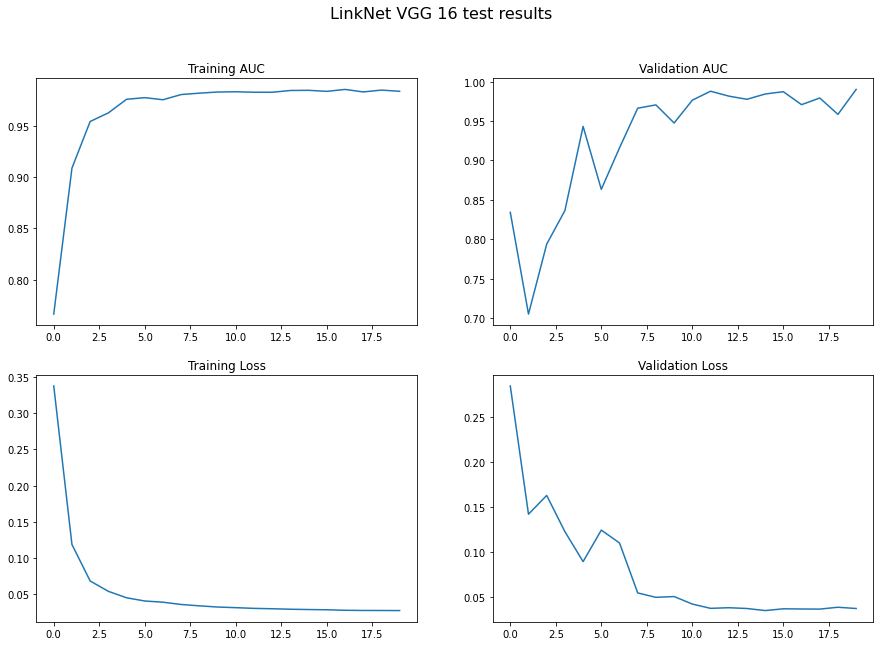

In [79]:
results = history
f, axarr = plt.subplots(2,2,figsize=(15,10))
axarr[0,0].plot(results.history['auc'])
axarr[0,0].set_title('Training AUC')
axarr[0,1].plot(results.history['val_auc'])
axarr[0,1].set_title('Validation AUC')

axarr[1,0].plot(results.history['loss'])
axarr[1,0].set_title('Training Loss')
axarr[1,1].plot(results.history['val_loss'])
axarr[1,1].set_title('Validation Loss')

f.suptitle('LinkNet VGG 16 test results', fontsize=16)
plt.show()

In [80]:
tst_vgg = model.predict(val_x)

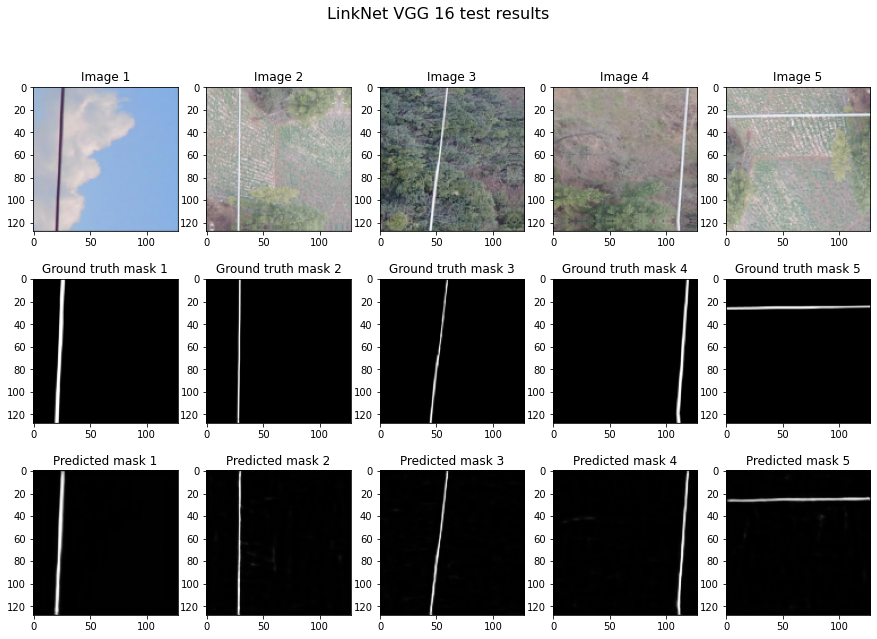

In [81]:
f, axarr = plt.subplots(3,5,figsize=(15,10))
axarr[0,0].imshow(val_x[idx[0]])
axarr[0,0].set_title('Image 1')
axarr[0,1].imshow(val_x[idx[1]])
axarr[0,1].set_title('Image 2')
axarr[0,2].imshow(val_x[idx[2]])
axarr[0,2].set_title('Image 3')
axarr[0,3].imshow(val_x[idx[3]])
axarr[0,3].set_title('Image 4')
axarr[0,4].imshow(val_x[idx[4]])
axarr[0,4].set_title('Image 5')
axarr[1,0].imshow(val_y[idx[0]][:,:,0],cmap='gray')
axarr[1,0].set_title('Ground truth mask 1')
axarr[1,1].imshow(val_y[idx[1]][:,:,0],cmap='gray')
axarr[1,1].set_title('Ground truth mask 2')
axarr[1,2].imshow(val_y[idx[2]][:,:,0],cmap='gray')
axarr[1,2].set_title('Ground truth mask 3')
axarr[1,3].imshow(val_y[idx[3]][:,:,0],cmap='gray')
axarr[1,3].set_title('Ground truth mask 4')
axarr[1,4].imshow(val_y[idx[4]][:,:,0],cmap='gray')
axarr[1,4].set_title('Ground truth mask 5')


axarr[2,0].imshow(tst_vgg[idx[0]][:,:,0],cmap='gray')
axarr[2,0].set_title('Predicted mask 1')
axarr[2,1].imshow(tst_vgg[idx[1]][:,:,0],cmap='gray')
axarr[2,1].set_title('Predicted mask 2')
axarr[2,2].imshow(tst_vgg[idx[2]][:,:,0],cmap='gray')
axarr[2,2].set_title('Predicted mask 3')
axarr[2,3].imshow(tst_vgg[idx[3]][:,:,0],cmap='gray')
axarr[2,3].set_title('Predicted mask 4')
axarr[2,4].imshow(tst_vgg[idx[4]][:,:,0],cmap='gray')
axarr[2,4].set_title('Predicted mask 5')
f.suptitle('LinkNet VGG 16 test results', fontsize=16)
plt.show()

In [82]:
vgg_ious = []

for i in thresholds:
  cpy = tst_vgg.copy()
  cpy[cpy >= i] = 1
  cpy[cpy < i] = 0
  vgg_ious.append(float(jacard_coef(val_y.astype('float32'),cpy)))

In [83]:
threshold = thresholds[np.argmax(vgg_ious)]

In [84]:
af_tst_vgg = tst_vgg.copy()
af_tst_vgg[af_tst_vgg >= threshold ] = 1
af_tst_vgg[af_tst_vgg < threshold ] = 0

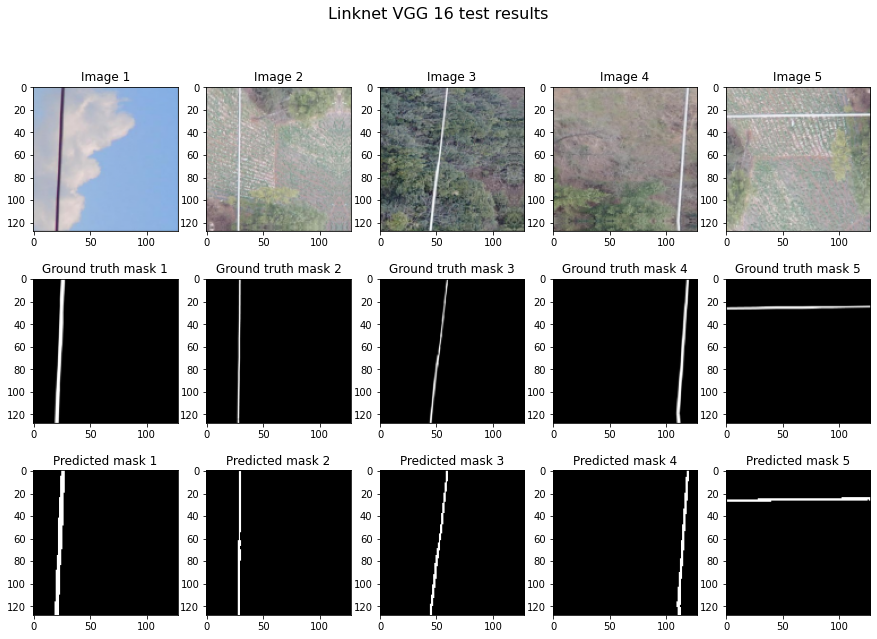

In [85]:
f, axarr = plt.subplots(3,5,figsize=(15,10))
axarr[0,0].imshow(val_x[idx[0]])
axarr[0,0].set_title('Image 1')
axarr[0,1].imshow(val_x[idx[1]])
axarr[0,1].set_title('Image 2')
axarr[0,2].imshow(val_x[idx[2]])
axarr[0,2].set_title('Image 3')
axarr[0,3].imshow(val_x[idx[3]])
axarr[0,3].set_title('Image 4')
axarr[0,4].imshow(val_x[idx[4]])
axarr[0,4].set_title('Image 5')
axarr[1,0].imshow(val_y[idx[0]][:,:,0],cmap='gray')
axarr[1,0].set_title('Ground truth mask 1')
axarr[1,1].imshow(val_y[idx[1]][:,:,0],cmap='gray')
axarr[1,1].set_title('Ground truth mask 2')
axarr[1,2].imshow(val_y[idx[2]][:,:,0],cmap='gray')
axarr[1,2].set_title('Ground truth mask 3')
axarr[1,3].imshow(val_y[idx[3]][:,:,0],cmap='gray')
axarr[1,3].set_title('Ground truth mask 4')
axarr[1,4].imshow(val_y[idx[4]][:,:,0],cmap='gray')
axarr[1,4].set_title('Ground truth mask 5')


axarr[2,0].imshow(af_tst_vgg[idx[0]][:,:,0],cmap='gray')
axarr[2,0].set_title('Predicted mask 1')
axarr[2,1].imshow(af_tst_vgg[idx[1]][:,:,0],cmap='gray')
axarr[2,1].set_title('Predicted mask 2')
axarr[2,2].imshow(af_tst_vgg[idx[2]][:,:,0],cmap='gray')
axarr[2,2].set_title('Predicted mask 3')
axarr[2,3].imshow(af_tst_vgg[idx[3]][:,:,0],cmap='gray')
axarr[2,3].set_title('Predicted mask 4')
axarr[2,4].imshow(af_tst_vgg[idx[4]][:,:,0],cmap='gray')
axarr[2,4].set_title('Predicted mask 5')
f.suptitle('Linknet VGG 16 test results', fontsize=16)
plt.show()

In [86]:
print('IoU score for the LinkNet VGG-16 backbone is: {} '.format(float(jacard_coef(val_y.astype('float32'),af_tst_vgg))))

IoU score for the LinkNet VGG-16 backbone is: 0.5596460103988647 


### VGG 19

In [87]:
BACKBONE = 'vgg19'

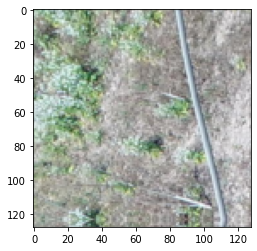

In [88]:
import matplotlib.pyplot as plt
plt.imshow(train_x[0])

In [89]:
model_linknet_vgg19 = 'models/linknet_vgg19'

In [90]:
num_thresholds = 15
model = sm.Linknet(BACKBONE)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['AUC'])


early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(model_linknet_vgg19, monitor='val_loss', mode='min', save_best_only=True, verbose=1,
                                       save_weights_only=True)
history = model.fit(train_x, train_y,
                        validation_split = 0.2,
                        epochs = 50,
                        batch_size=16,
                        callbacks=[early_stopping,model_checkpoint],
                        verbose=1)

Epoch 1/50
23/23 [==============================] - 12s 372ms/step - loss: 0.3654 - auc: 0.6761 - val_loss: 0.1585 - val_auc: 0.6077

Epoch 00001: val_loss improved from inf to 0.15854, saving model to models/linknet_vgg19
Epoch 2/50
23/23 [==============================] - 8s 337ms/step - loss: 0.1127 - auc: 0.9077 - val_loss: 0.1815 - val_auc: 0.6261

Epoch 00002: val_loss did not improve from 0.15854
Epoch 3/50
23/23 [==============================] - 8s 337ms/step - loss: 0.0667 - auc: 0.9539 - val_loss: 0.3092 - val_auc: 0.6443

Epoch 00003: val_loss did not improve from 0.15854
Epoch 4/50
23/23 [==============================] - 8s 335ms/step - loss: 0.0524 - auc: 0.9549 - val_loss: 0.1533 - val_auc: 0.8248

Epoch 00004: val_loss improved from 0.15854 to 0.15333, saving model to models/linknet_vgg19
Epoch 5/50
23/23 [==============================] - 8s 335ms/step - loss: 0.0451 - auc: 0.9661 - val_loss: 0.0620 - val_auc: 0.9222

Epoch 00005: val_loss improved from 0.15333 to 0.0

In [91]:
model.load_weights(model_linknet_vgg19)

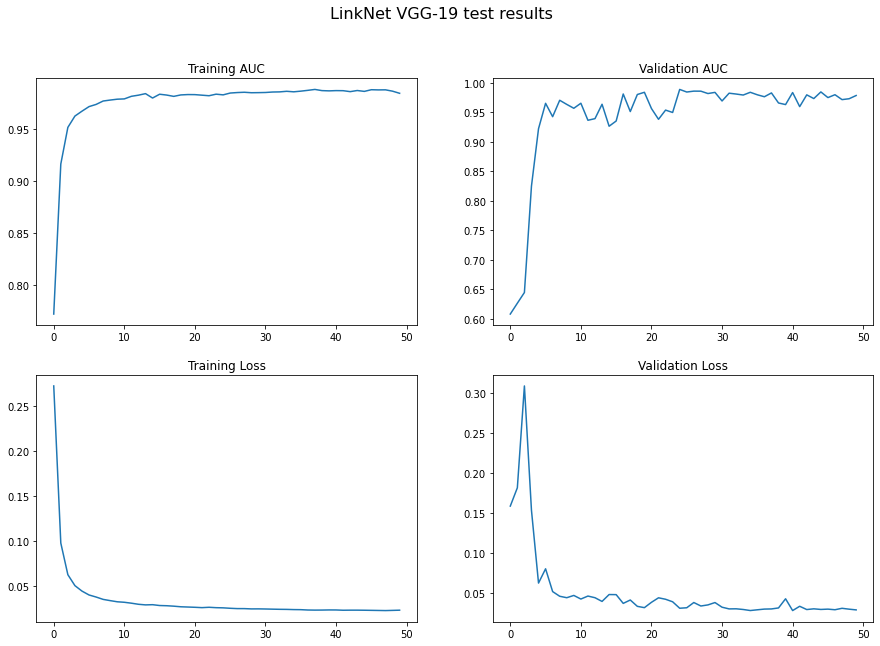

In [92]:
results = history
f, axarr = plt.subplots(2,2,figsize=(15,10))
axarr[0,0].plot(results.history['auc'])
axarr[0,0].set_title('Training AUC')
axarr[0,1].plot(results.history['val_auc'])
axarr[0,1].set_title('Validation AUC')

axarr[1,0].plot(results.history['loss'])
axarr[1,0].set_title('Training Loss')
axarr[1,1].plot(results.history['val_loss'])
axarr[1,1].set_title('Validation Loss')

f.suptitle('LinkNet VGG-19 test results', fontsize=16)
plt.show()

In [93]:
tst_vgg19 = model.predict(val_x)

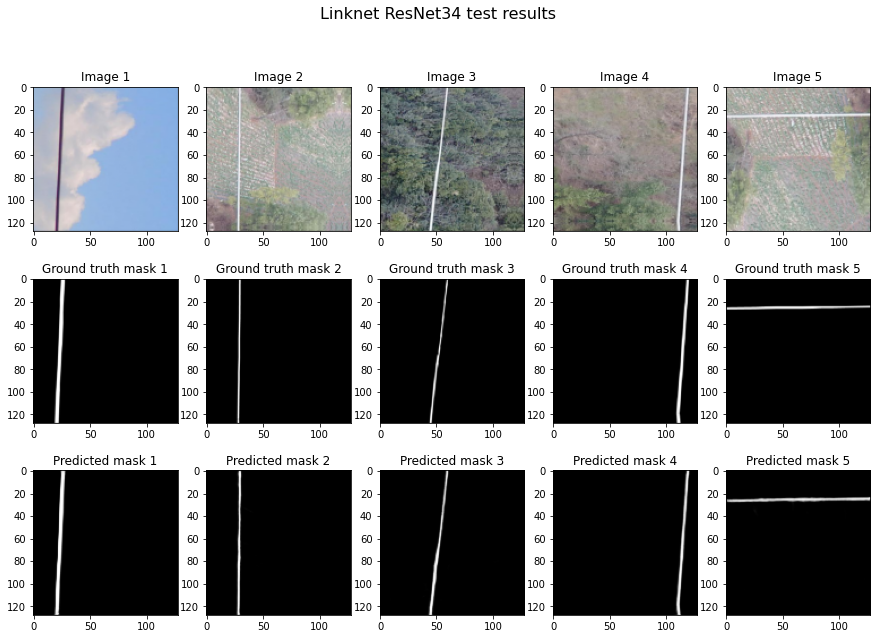

In [94]:
f, axarr = plt.subplots(3,5,figsize=(15,10))
axarr[0,0].imshow(val_x[idx[0]])
axarr[0,0].set_title('Image 1')
axarr[0,1].imshow(val_x[idx[1]])
axarr[0,1].set_title('Image 2')
axarr[0,2].imshow(val_x[idx[2]])
axarr[0,2].set_title('Image 3')
axarr[0,3].imshow(val_x[idx[3]])
axarr[0,3].set_title('Image 4')
axarr[0,4].imshow(val_x[idx[4]])
axarr[0,4].set_title('Image 5')
axarr[1,0].imshow(val_y[idx[0]][:,:,0],cmap='gray')
axarr[1,0].set_title('Ground truth mask 1')
axarr[1,1].imshow(val_y[idx[1]][:,:,0],cmap='gray')
axarr[1,1].set_title('Ground truth mask 2')
axarr[1,2].imshow(val_y[idx[2]][:,:,0],cmap='gray')
axarr[1,2].set_title('Ground truth mask 3')
axarr[1,3].imshow(val_y[idx[3]][:,:,0],cmap='gray')
axarr[1,3].set_title('Ground truth mask 4')
axarr[1,4].imshow(val_y[idx[4]][:,:,0],cmap='gray')
axarr[1,4].set_title('Ground truth mask 5')


axarr[2,0].imshow(tst_vgg19[idx[0]][:,:,0],cmap='gray')
axarr[2,0].set_title('Predicted mask 1')
axarr[2,1].imshow(tst_vgg19[idx[1]][:,:,0],cmap='gray')
axarr[2,1].set_title('Predicted mask 2')
axarr[2,2].imshow(tst_vgg19[idx[2]][:,:,0],cmap='gray')
axarr[2,2].set_title('Predicted mask 3')
axarr[2,3].imshow(tst_vgg19[idx[3]][:,:,0],cmap='gray')
axarr[2,3].set_title('Predicted mask 4')
axarr[2,4].imshow(tst_vgg19[idx[4]][:,:,0],cmap='gray')
axarr[2,4].set_title('Predicted mask 5')
f.suptitle('Linknet ResNet34 test results', fontsize=16)
plt.show()

In [95]:
vgg19_ious = []

for i in thresholds:
  cpy = tst_vgg19.copy()
  cpy[cpy >= i] = 1
  cpy[cpy < i] = 0
  vgg19_ious.append(float(jacard_coef(val_y.astype('float32'),cpy)))

In [96]:
threshold = thresholds[np.argmax(vgg19_ious)]

In [97]:
af_tst_vgg19 = tst_vgg19.copy()
af_tst_vgg19[af_tst_vgg19 >= threshold ] = 1
af_tst_vgg19[af_tst_vgg19 < threshold ] = 0

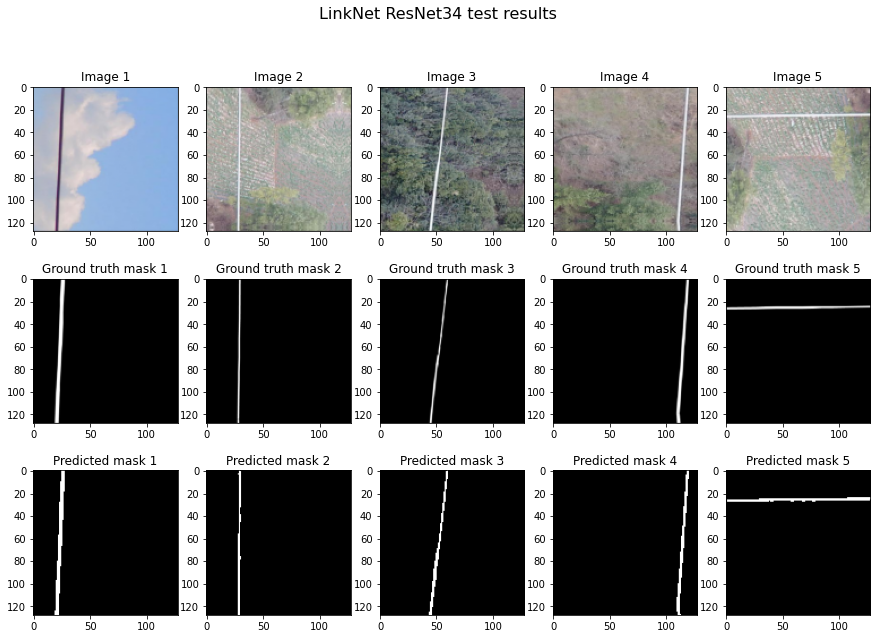

In [98]:
f, axarr = plt.subplots(3,5,figsize=(15,10))
axarr[0,0].imshow(val_x[idx[0]])
axarr[0,0].set_title('Image 1')
axarr[0,1].imshow(val_x[idx[1]])
axarr[0,1].set_title('Image 2')
axarr[0,2].imshow(val_x[idx[2]])
axarr[0,2].set_title('Image 3')
axarr[0,3].imshow(val_x[idx[3]])
axarr[0,3].set_title('Image 4')
axarr[0,4].imshow(val_x[idx[4]])
axarr[0,4].set_title('Image 5')
axarr[1,0].imshow(val_y[idx[0]][:,:,0],cmap='gray')
axarr[1,0].set_title('Ground truth mask 1')
axarr[1,1].imshow(val_y[idx[1]][:,:,0],cmap='gray')
axarr[1,1].set_title('Ground truth mask 2')
axarr[1,2].imshow(val_y[idx[2]][:,:,0],cmap='gray')
axarr[1,2].set_title('Ground truth mask 3')
axarr[1,3].imshow(val_y[idx[3]][:,:,0],cmap='gray')
axarr[1,3].set_title('Ground truth mask 4')
axarr[1,4].imshow(val_y[idx[4]][:,:,0],cmap='gray')
axarr[1,4].set_title('Ground truth mask 5')


axarr[2,0].imshow(af_tst_vgg19[idx[0]][:,:,0],cmap='gray')
axarr[2,0].set_title('Predicted mask 1')
axarr[2,1].imshow(af_tst_vgg19[idx[1]][:,:,0],cmap='gray')
axarr[2,1].set_title('Predicted mask 2')
axarr[2,2].imshow(af_tst_vgg19[idx[2]][:,:,0],cmap='gray')
axarr[2,2].set_title('Predicted mask 3')
axarr[2,3].imshow(af_tst_vgg19[idx[3]][:,:,0],cmap='gray')
axarr[2,3].set_title('Predicted mask 4')
axarr[2,4].imshow(af_tst_vgg19[idx[4]][:,:,0],cmap='gray')
axarr[2,4].set_title('Predicted mask 5')
f.suptitle('LinkNet ResNet34 test results', fontsize=16)
plt.show()

In [99]:
print('IoU score for the VGG 19  backbone is: {} '.format(float(jacard_coef(val_y.astype('float32'),af_tst_vgg19))))

IoU score for the VGG 19  backbone is: 0.5891985893249512 


### Inception V3

In [100]:
BACKBONE = 'inceptionv3'

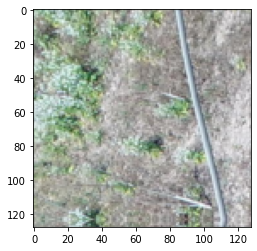

In [101]:
import matplotlib.pyplot as plt
plt.imshow(train_x[0])

In [102]:
model_linknet_inception = 'models/linknet_inception'

In [103]:
num_thresholds = 15
model = sm.Linknet(BACKBONE)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['AUC'])


early_stopping = EarlyStopping(patience=5, verbose=1)
model_checkpoint = ModelCheckpoint(model_linknet_inception, monitor='val_loss', mode='min', save_best_only=True, verbose=1,
                                       save_weights_only=True)
history = model.fit(train_x, train_y,
                        validation_split = 0.2,
                        epochs = 50,
                        batch_size=16,
                        callbacks=[early_stopping,model_checkpoint],
                        verbose=1)

Epoch 1/50
23/23 [==============================] - 21s 468ms/step - loss: 0.5158 - auc: 0.6209 - val_loss: 364.7427 - val_auc: 0.4987

Epoch 00001: val_loss improved from inf to 364.74268, saving model to models/linknet_inception
Epoch 2/50
23/23 [==============================] - 8s 331ms/step - loss: 0.1742 - auc: 0.8324 - val_loss: 8.5402 - val_auc: 0.4988

Epoch 00002: val_loss improved from 364.74268 to 8.54022, saving model to models/linknet_inception
Epoch 3/50
23/23 [==============================] - 8s 330ms/step - loss: 0.0891 - auc: 0.9239 - val_loss: 0.1610 - val_auc: 0.5402

Epoch 00003: val_loss improved from 8.54022 to 0.16103, saving model to models/linknet_inception
Epoch 4/50
23/23 [==============================] - 8s 330ms/step - loss: 0.0638 - auc: 0.9541 - val_loss: 0.2327 - val_auc: 0.7107

Epoch 00004: val_loss did not improve from 0.16103
Epoch 5/50
23/23 [==============================] - 8s 331ms/step - loss: 0.0499 - auc: 0.9686 - val_loss: 0.3209 - val_auc

In [104]:
model.load_weights(model_linknet_inception)

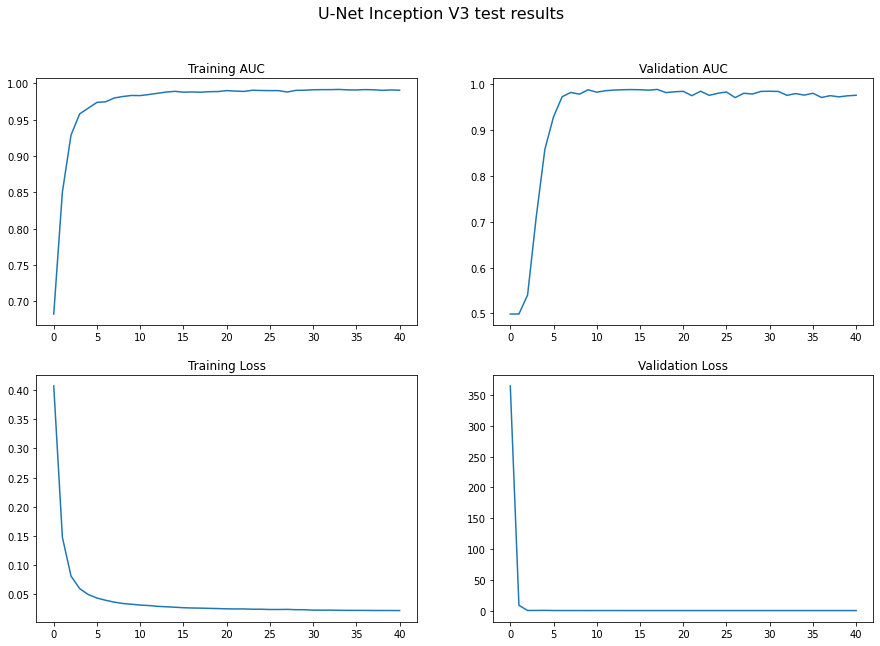

In [105]:
results = history
f, axarr = plt.subplots(2,2,figsize=(15,10))
axarr[0,0].plot(results.history['auc'])
axarr[0,0].set_title('Training AUC')
axarr[0,1].plot(results.history['val_auc'])
axarr[0,1].set_title('Validation AUC')

axarr[1,0].plot(results.history['loss'])
axarr[1,0].set_title('Training Loss')
axarr[1,1].plot(results.history['val_loss'])
axarr[1,1].set_title('Validation Loss')

f.suptitle('U-Net Inception V3 test results', fontsize=16)
plt.show()

In [106]:
tst_inception = model.predict(val_x)

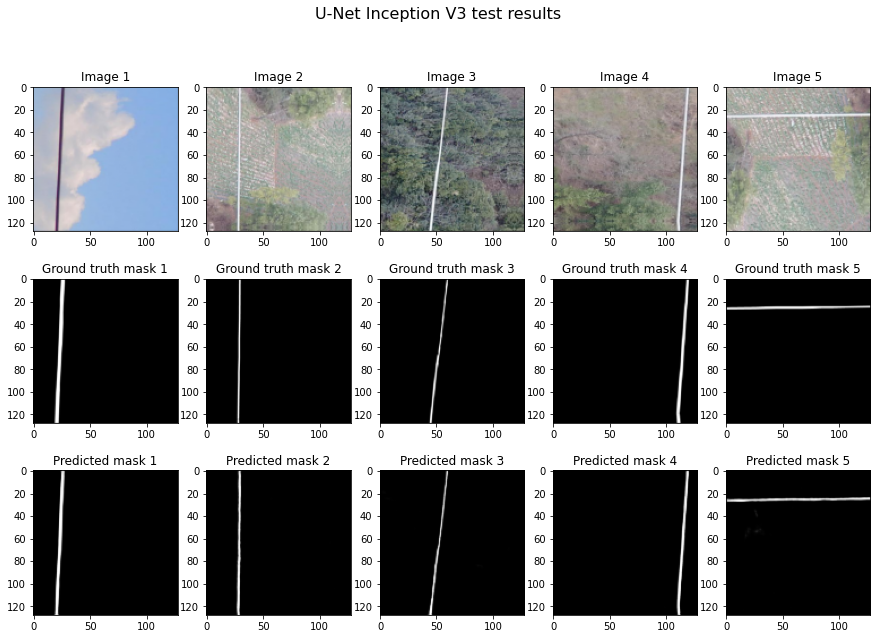

In [107]:
f, axarr = plt.subplots(3,5,figsize=(15,10))
axarr[0,0].imshow(val_x[idx[0]])
axarr[0,0].set_title('Image 1')
axarr[0,1].imshow(val_x[idx[1]])
axarr[0,1].set_title('Image 2')
axarr[0,2].imshow(val_x[idx[2]])
axarr[0,2].set_title('Image 3')
axarr[0,3].imshow(val_x[idx[3]])
axarr[0,3].set_title('Image 4')
axarr[0,4].imshow(val_x[idx[4]])
axarr[0,4].set_title('Image 5')
axarr[1,0].imshow(val_y[idx[0]][:,:,0],cmap='gray')
axarr[1,0].set_title('Ground truth mask 1')
axarr[1,1].imshow(val_y[idx[1]][:,:,0],cmap='gray')
axarr[1,1].set_title('Ground truth mask 2')
axarr[1,2].imshow(val_y[idx[2]][:,:,0],cmap='gray')
axarr[1,2].set_title('Ground truth mask 3')
axarr[1,3].imshow(val_y[idx[3]][:,:,0],cmap='gray')
axarr[1,3].set_title('Ground truth mask 4')
axarr[1,4].imshow(val_y[idx[4]][:,:,0],cmap='gray')
axarr[1,4].set_title('Ground truth mask 5')


axarr[2,0].imshow(tst_inception[idx[0]][:,:,0],cmap='gray')
axarr[2,0].set_title('Predicted mask 1')
axarr[2,1].imshow(tst_inception[idx[1]][:,:,0],cmap='gray')
axarr[2,1].set_title('Predicted mask 2')
axarr[2,2].imshow(tst_inception[idx[2]][:,:,0],cmap='gray')
axarr[2,2].set_title('Predicted mask 3')
axarr[2,3].imshow(tst_inception[idx[3]][:,:,0],cmap='gray')
axarr[2,3].set_title('Predicted mask 4')
axarr[2,4].imshow(tst_inception[idx[4]][:,:,0],cmap='gray')
axarr[2,4].set_title('Predicted mask 5')
f.suptitle('U-Net Inception V3 test results', fontsize=16)
plt.show()

In [108]:
inception_ious = []

for i in thresholds:
  cpy = tst_inception.copy()
  cpy[cpy >= i] = 1
  cpy[cpy < i] = 0
  inception_ious.append(float(jacard_coef(val_y.astype('float32'),cpy)))

In [109]:
threshold = thresholds[np.argmax(inception_ious)]

In [110]:
af_tst_inception = tst_inception.copy()
af_tst_inception[af_tst_inception >= threshold ] = 1
af_tst_inception[af_tst_inception < threshold ] = 0

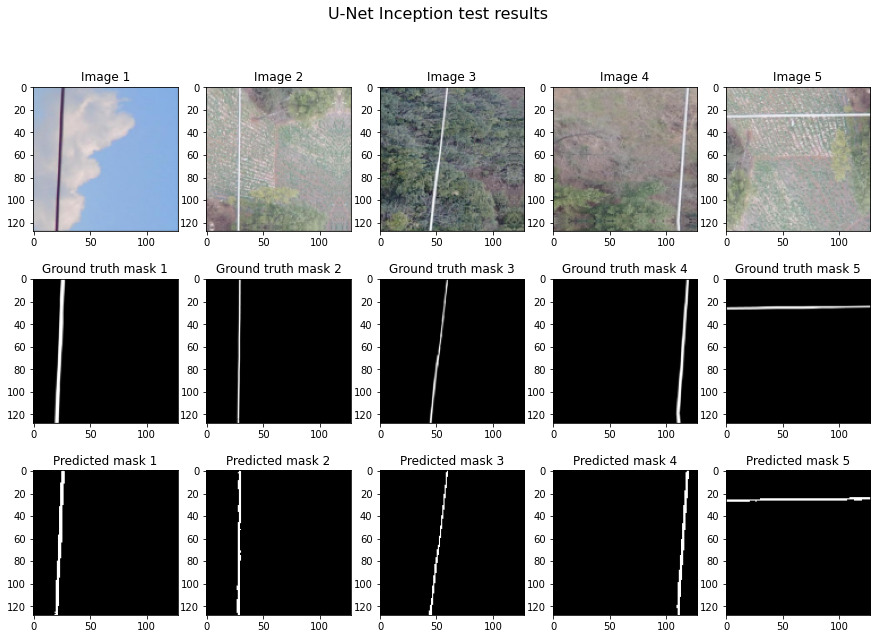

In [111]:
f, axarr = plt.subplots(3,5,figsize=(15,10))
axarr[0,0].imshow(val_x[idx[0]])
axarr[0,0].set_title('Image 1')
axarr[0,1].imshow(val_x[idx[1]])
axarr[0,1].set_title('Image 2')
axarr[0,2].imshow(val_x[idx[2]])
axarr[0,2].set_title('Image 3')
axarr[0,3].imshow(val_x[idx[3]])
axarr[0,3].set_title('Image 4')
axarr[0,4].imshow(val_x[idx[4]])
axarr[0,4].set_title('Image 5')
axarr[1,0].imshow(val_y[idx[0]][:,:,0],cmap='gray')
axarr[1,0].set_title('Ground truth mask 1')
axarr[1,1].imshow(val_y[idx[1]][:,:,0],cmap='gray')
axarr[1,1].set_title('Ground truth mask 2')
axarr[1,2].imshow(val_y[idx[2]][:,:,0],cmap='gray')
axarr[1,2].set_title('Ground truth mask 3')
axarr[1,3].imshow(val_y[idx[3]][:,:,0],cmap='gray')
axarr[1,3].set_title('Ground truth mask 4')
axarr[1,4].imshow(val_y[idx[4]][:,:,0],cmap='gray')
axarr[1,4].set_title('Ground truth mask 5')


axarr[2,0].imshow(af_tst_inception[idx[0]][:,:,0],cmap='gray')
axarr[2,0].set_title('Predicted mask 1')
axarr[2,1].imshow(af_tst_inception[idx[1]][:,:,0],cmap='gray')
axarr[2,1].set_title('Predicted mask 2')
axarr[2,2].imshow(af_tst_inception[idx[2]][:,:,0],cmap='gray')
axarr[2,2].set_title('Predicted mask 3')
axarr[2,3].imshow(af_tst_inception[idx[3]][:,:,0],cmap='gray')
axarr[2,3].set_title('Predicted mask 4')
axarr[2,4].imshow(af_tst_inception[idx[4]][:,:,0],cmap='gray')
axarr[2,4].set_title('Predicted mask 5')
f.suptitle('U-Net Inception test results', fontsize=16)
plt.show()

In [112]:
print('IoU score for the ResNet 34  backbone is: {} '.format(float(jacard_coef(val_y.astype('float32'),af_tst_inception))))

IoU score for the ResNet 34  backbone is: 0.5964136123657227 


#### Conclusion about U-Net model
Best backbone: **Inception V3** \\
Reason: High IoU

# Conclusion for PLDM 

## Best Model : LinkNet Inception V3